In [1428]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Proof that reducing r^2 gives a hebbian learning rule. also, Es are reduced when weights are random. For Scalars

In [1488]:
def step(x, e, r, U):
    with torch.no_grad():
        e = x - F.linear(r, U.weight.T, U.bias)
        if U.bias is not None:
            e1 = e + U.bias
    r = r + F.linear(e, U.weight, None) 
    return e, r

In [1499]:
# Parameter Initialisation
U = nn.Linear(1,1, bias=False)
print(f"U: {U.weight.data.item():.4f}")

U: -0.2976


In [1500]:
# Data Initialisation
# x = torch.rand(1)
x = torch.tensor([3.0])
e = torch.zeros(1)
r = torch.zeros(1)

print(f"x: {x.item():.4f}")
print(f"e: {e.item():.4f}")
print(f"r: {r.item():.4f}")

x: 3.0000
e: 0.0000
r: 0.0000


In [1553]:
# Iterate 
# for _ in range(20): # 20 - pred = 2.9625 
#     e, r = step(x, e, r, U)

e = e.detach()
r = r.detach()
e, r = step(x, e, r, U)


print(f"x: {x.item():.4f}")
print(f"pred: {F.linear(r, U.weight.T, U.bias).item():.4f}")
print(f"e: {e.item():.4f}")
print(f"r: {r.item():.4f}")

x: 3.0000
pred: 2.9780
e: 0.0241
r: -10.0066


In [1425]:
U.zero_grad()
with torch.no_grad():
    U.weight.grad = torch.zeros_like(U.weight)
loss = -0.5*((r**2).sum())
loss.sum().backward()
print(f'U.weight.grad: {U.weight.grad.item():.4f}')
print(f'e.r: {torch.matmul(e.unsqueeze(1), r.unsqueeze(1).T).item():.4f}')
lr = 0.1
U.weight.data -= lr * U.weight.grad
U.weight.data.item()

U.weight.grad: 0.0153
e.r: -0.0153


-1.0006821155548096

In [1485]:
# Parameter Initialisation
U = nn.Linear(1,1, bias=False)
print(f"U: {U.weight.data.item():.4f}")
preds = []
Us = []
es = []

U: 0.5133


In [1486]:
lr = 0.01
epochs = 3

for _ in range(epochs):
    # Data Initialisation
    # x = torch.rand(1)
    x = torch.tensor([-4.0])
    e = torch.zeros(1)
    r = torch.zeros(1)

    # Forward Pass
    for _ in range(2):
        e = e.detach()
        r = r.detach()
        e, r = step(x, e, r, U)

    # Hebb Learn
    U.zero_grad()
    with torch.no_grad():
        U.weight.grad = torch.zeros_like(U.weight)
    loss = -0.5*((r**2).sum())
    loss.backward()
    U.weight.data -= lr * U.weight.grad

    preds.append(F.linear(r, U.weight.T, U.bias).item())
    Us.append(U.weight.data.item())
    es.append(e.item())

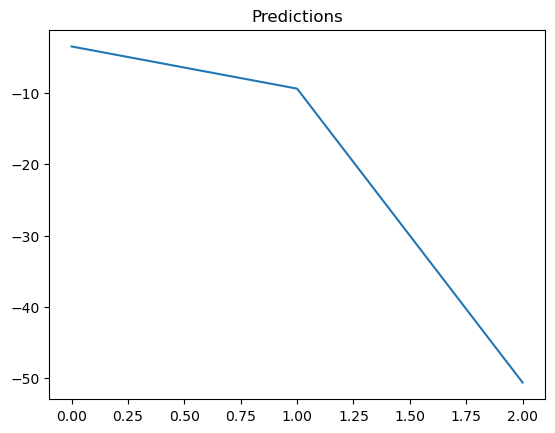

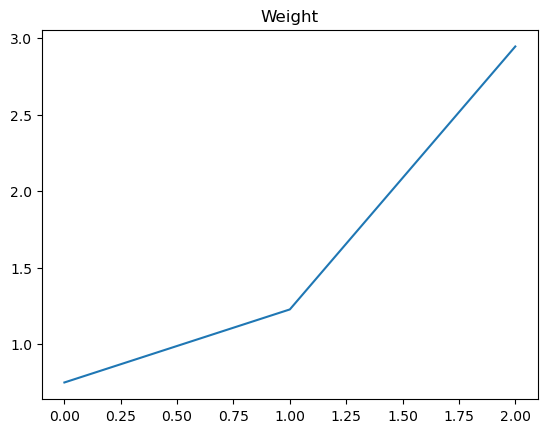

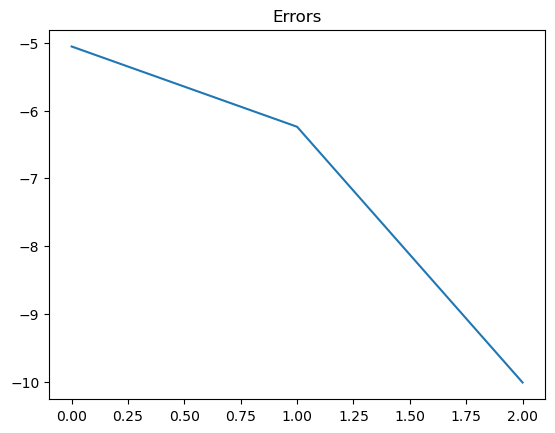

In [1487]:
plt.plot(preds)
plt.title('Predictions')
plt.show()
plt.plot(Us)
plt.title('Weight')
plt.show()
plt.plot(es,)
plt.title('Errors')
plt.show()

1:
tensor([[-6.1374]], grad_fn=<PermuteBackward0>)


Expansion to Vector Es and Rs